## Import Packages

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from fbprophet import Prophet
import itertools

#Split
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
#Feature selection / dimension reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV,SelectPercentile,mutual_info_classif
import statsmodels.api as sm
#Performance evaluation
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


np.random.seed(seed=1)

## Data preprocessing

In [39]:
df = pd.read_csv('grocery_store_data_cleaned.csv',index_col=0)
df['DATE'] = pd.to_datetime(df['DATE']) 
df.drop(columns=['REFERENCE', 'CODE'], inplace=True)
df.head()

,TICKET,UNITS,NAME,UNIT_PRICEBUY,UNIT_PRICESELL,DATE,PAYMENT,TRANSID,CATEGORY,TOTAL_PRICEBUY,TOTAL_PRICESELL,UNIT_PRICE_MARGIN,PROFIT
0,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:15:39,cash,no ID,Pumpkins,0.000,6.55108,1.99,6.55108
1,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,0.290,Orange navel,0.0,2.99,2016-03-16 23:15:39,cash,no ID,Citrus,0.000,0.86710,2.99,0.86710
2,f4dd518d-1fd8-4339-abc6-2c5390c20e30,-1.000,Orange navel,0.0,2.99,2016-03-16 23:17:35,cashrefund,NaN,Citrus,-0.000,-2.99000,2.99,-2.99000
3,aa299de6-1332-48ba-bce9-de8cbb48741e,3.292,Australian Asparagus green,2.0,2.70,2016-03-16 23:19:47,cash,no ID,Bunch Vegies,6.584,8.88840,0.70,2.30440
4,aa299de6-1332-48ba-bce9-de8cbb48741e,1.000,Nice Munchee 200g,0.9,1.50,2016-03-16 23:19:47,cash,no ID,Sri Lankan Groceries,0.900,1.50000,0.60,0.60000


In [40]:
df.dtypes

TICKET                       object
UNITS                       float64
NAME                         object
UNIT_PRICEBUY               float64
UNIT_PRICESELL              float64
DATE                 datetime64[ns]
PAYMENT                      object
TRANSID                      object
CATEGORY                     object
TOTAL_PRICEBUY              float64
TOTAL_PRICESELL             float64
UNIT_PRICE_MARGIN           float64
PROFIT                      float64
dtype: object

In [41]:
df['yyyymmdd'] = [d.date() for d in df['DATE']]
df['Month'] = [d.date().month for d in df['DATE']]
df['Day'] = [d.date().day for d in df['DATE']]
df['Month'].astype(float)
df['Day'].astype(float)
#df_daily = df.groupby(pd.to_datetime(df.yyyymmdd).dt.date).agg({'Day':'first','Month':'first', 'TOTAL_PRICEBUY': 'sum', 'TOTAL_PRICESELL':'sum'}).reset_index()

#df_daily = df_daily.set_index(pd.DatetimeIndex(df_daily['yyyymmdd']))

0         16.0
1         16.0
2         16.0
3         16.0
4         16.0
          ... 
659216    13.0
659217    13.0
659218    13.0
659219    13.0
659220    13.0
Name: Day, Length: 659221, dtype: float64

In [42]:
#df_daily['Daily Profit'] = df_daily['TOTAL_PRICESELL'] - df_daily['TOTAL_PRICEBUY']
#df_daily['Cumulative Sales'] = df_daily['TOTAL_PRICESELL'].cumsum()

#df_daily['Forward Daily Profit'] = df_daily['Daily Profit'].shift(-1)

#df_daily = df_daily.dropna()
#df_daily


In [43]:
df['catstr'] = df['CATEGORY'].astype(str)
df['catstr'].unique()

array(['Pumpkins', 'Citrus', 'Bunch Vegies', 'Sri Lankan Groceries',
       'Other Vegies', 'Veggies', 'Cabbages', 'Asian Vegies',
       'Stonefruits', 'Onions', 'carrots', 'Tropical Fruits', 'Melons',
       'Grapes', 'Potatoes', 'Tomatoes', 'Cucumbers', 'Bananas', 'Apples',
       'Pears', 'Chillies', 'Other Fruits', 'Nuts', 'Herbs', 'Mushrooms',
       'Lettuces', 'capsicum', 'Root Vegies', 'Multi buy', 'Eggs',
       'Avocadoes', 'Berries', 'Cut Veggies', 'Flowers',
       'Olympian Products', 'Groceries-Dry Goods', 'Cut Fruits',
       'Kalamata olives', 'coconut Products', 'Fruits', 'trutaste',
       'Pastas', 'markdown bag'], dtype=object)

In [44]:
df

,TICKET,UNITS,NAME,UNIT_PRICEBUY,UNIT_PRICESELL,DATE,PAYMENT,TRANSID,CATEGORY,TOTAL_PRICEBUY,TOTAL_PRICESELL,UNIT_PRICE_MARGIN,PROFIT,yyyymmdd,Month,Day,catstr
0,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:15:39,cash,no ID,Pumpkins,0.000,6.55108,1.99,6.55108,2016-03-16,3,16,Pumpkins
1,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,0.290,Orange navel,0.0,2.99,2016-03-16 23:15:39,cash,no ID,Citrus,0.000,0.86710,2.99,0.86710,2016-03-16,3,16,Citrus
2,f4dd518d-1fd8-4339-abc6-2c5390c20e30,-1.000,Orange navel,0.0,2.99,2016-03-16 23:17:35,cashrefund,NaN,Citrus,-0.000,-2.99000,2.99,-2.99000,2016-03-16,3,16,Citrus
3,aa299de6-1332-48ba-bce9-de8cbb48741e,3.292,Australian Asparagus green,2.0,2.70,2016-03-16 23:19:47,cash,no ID,Bunch Vegies,6.584,8.88840,0.70,2.30440,2016-03-16,3,16,Bunch Vegies
4,aa299de6-1332-48ba-bce9-de8cbb48741e,1.000,Nice Munchee 200g,0.9,1.50,2016-03-16 23:19:47,cash,no ID,Sri Lankan Groceries,0.900,1.50000,0.60,0.60000,2016-03-16,3,16,Sri Lankan Groceries
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659216,5cb041e2-1976-45b4-ba06-7779d6893156,1.000,Curry powder250g kandyan,2.0,3.99,2019-10-13 17:41:45,magcard,904210501806,Sri Lankan Groceries,2.000,3.99000,1.99,1.99000,2019-10-13,10,13,Sri Lankan Groceries
659217,5cb041e2-1976-45b4-ba06-7779d6893156,1.042,Banana Cavendish,2.0,1.99,2019-10-13 17:41:45,magcard,904210501806,Bananas,2.084,2.07358,-0.01,-0.01042,2019-10-13,10,13,Bananas
659218,5cb041e2-1976-45b4-ba06-7779d6893156,1.000,Tomatoes Cherry,0.0,3.00,2019-10-13 17:41:45,magcard,904210501806,Tomatoes,0.000,3.00000,3.00,3.00000,2019-10-13,10,13,Tomatoes
659219,8e1e8d7c-9247-44bc-b50e-dd01acb68974,0.382,Onion brown,0.0,1.99,2019-10-13 17:43:20,cash,no ID,Onions,0.000,0.76018,1.99,0.76018,2019-10-13,10,13,Onions


In [45]:
#df[df['CATEGORY'] == 'Citrus'].groupby(df['yyyymmdd']).sum()

## Linear and Time Series Models

In [46]:
from sklearn.linear_model import LinearRegression, Ridge,SGDRegressor,ElasticNet,Lars,Lasso,BayesianRidge
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor

#dictionary of regression models 
regressors = {}
regressors.update({"Linear":LinearRegression()})
regressors.update({"Ridge":Ridge()})
regressors.update({"SGD":SGDRegressor()})
regressors.update({"ElasticNet":ElasticNet()})
regressors.update({"Lars":Lars()})
regressors.update({"Lasso":Lasso()})
regressors.update({"BayesianRidge":BayesianRidge()})
regressors.update({"DecisionTreeRegressor":DecisionTreeRegressor()})
regressors.update({"ExtraTree":ExtraTreeRegressor()})
regressors.update({"Bagging":BaggingRegressor()})
regressors.update({"RandomForest":RandomForestRegressor()})


## Stationarity Test

In [47]:
categories = df.CATEGORY.unique()
categories

def create_single_series(data, col_name, cat, freq='NA'):
  #Function changes the frequency of the time series based on the and selectes a 
  #certain column with the variable cat.
    if freq == 'NA':
        freq_data = data.loc[data.CATEGORY == cat,f'{col_name.upper()}']
        return freq_data
    else:
        freq_data = data.loc[data.CATEGORY == cat,f'{col_name.upper()}']
        freq_data = freq_data.resample(freq).sum()
        return freq_data

In [48]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, cat, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
        adf['Critical Value (%s)'%key] = value
    
    p = adf['p-value']
    if p <= signif:
        print(f"{cat} Series is Stationary")
        return True
    else:
        print('')
        print(adf)
        print(f"{cat} Series is Non-Stationary")
        print('')
        return False

In [49]:
stationary_series = []
temp_df = df.set_index('DATE')
for cate in categories:
    series = create_single_series(temp_df,col_name='TOTAL_PRICESELL',cat=cate, freq='1D')
    test_res = adf_test(series, cate)
    if test_res:
        stationary_series.append(cate)
    else:
        continue


Pumpkins Series is Stationary

Test Statistic            -2.039310
p-value                    0.269607
# Lags                    20.000000
# Observations          1286.000000
Critical Value (1%)       -3.435445
Critical Value (5%)       -2.863790
Critical Value (10%)      -2.567968
dtype: float64
Citrus Series is Non-Stationary

Bunch Vegies Series is Stationary
Sri Lankan Groceries Series is Stationary
Other Vegies Series is Stationary
Veggies Series is Stationary
Cabbages Series is Stationary
Asian Vegies Series is Stationary

Test Statistic            -2.393966
p-value                    0.143447
# Lags                    22.000000
# Observations          1157.000000
Critical Value (1%)       -3.436015
Critical Value (5%)       -2.864041
Critical Value (10%)      -2.568102
dtype: float64
Stonefruits Series is Non-Stationary

Onions Series is Stationary
carrots Series is Stationary
Tropical Fruits Series is Stationary
Melons Series is Stationary

Test Statistic            -2.486847
p

In [50]:
series

DATE
2016-09-28     1.0
2016-09-29    22.0
2016-09-30    17.0
2016-10-01    29.0
2016-10-02    33.0
              ... 
2019-10-09     3.0
2019-10-10     5.0
2019-10-11     6.0
2019-10-12    15.0
2019-10-13     2.0
Freq: D, Name: TOTAL_PRICESELL, Length: 1111, dtype: float64

## Helper Functions for testing performance

In [51]:
def ML_record_performance(df_results, model_name, y_train_hat, y_train,y_test_hat,y_test,pred_future):
    #Takes in df_results,y_hat and true y for both in and out of sample
    #Record training and testing MSE
    in_sample_mse = metrics.mean_squared_error(y_train_hat, y_train)
    out_of_sample_mse = metrics.mean_squared_error(y_test_hat, y_test)
#     print(in_sample_mse)
#     print(out_of_sample_mse)
    #Return updated df_results
    
    df_results.loc[model_name] = [in_sample_mse, out_of_sample_mse,pred_future[-1]]

def ML_model_pipeline(df_results, category, model_name, model_object, X_train_raw, X_test_raw, y_train, y_test,last_row):
    #Takes in sklearn's model object, and train & test data
    # Model object passed in by the dictionary (value store is passed in)
    model_curr = model_object
    #USE RFECV function to find the best subset of features for the model to get X_train
    # Using model_object as estimator
    try: 
        rfecv = RFECV(estimator=model_curr, step=1, cv=5, scoring='neg_mean_squared_error')   
        rfecv = rfecv.fit(X_train_raw, y_train)

        #Transform X_test based on feature selection 
        X_train_raw = X_train_raw[X_train_raw.columns[rfecv.support_]]
        X_test_raw = X_test_raw[X_test_raw.columns[rfecv.support_]]
        last_row = last_row[last_row.columns[rfecv.support_]]
    except:
        pass

    #Fit train data
    model_curr.fit(X_train_raw, y_train)
    #Predict train data
    train_predicted = model_curr.predict(X_train_raw)
    #Predict testing data
    test_predicted = model_curr.predict(X_test_raw)
    
    #predict 3 month in future
    pred_future = model_curr.predict(last_row)
    #record in sample MSE and out of sample MSE by calling the record_performance function
    ML_record_performance(df_results, model_name, train_predicted, y_train, test_predicted, y_test,pred_future)
    # Recording selected features for given model 
    dict_selected_features[category][model_name] = X_train_raw.columns

def TS_record_performance(df_results, model_name, y_train_hat, y_train,y_test_hat,y_test,pred_future):
    #TOO DOO RAAAHIIIIIIMM

    #Takes in df_results,y_hat and true y for both in and out of sample
    #Record training and testing MSE

    ##########################################################################
    in_sample_mse = metrics.mean_squared_error(y_train_hat, y_train)
    out_of_sample_mse = metrics.mean_squared_error(y_test_hat, y_test)
    #Return updated df_results
    ###########################################################################
#     print(in_sample_mse)
#     print(out_of_sample_mse)
#     #Return updated df_results
    pred_future = np.asarray(pred_future, dtype=np.float64)
    df_results.loc[model_name] = [in_sample_mse, out_of_sample_mse,pred_future[-1]]


def TS_model_pipeline(df_results, category, model_name,y_train, y_test,additional_steps) :

    #creating series
    #X_train_series = X_train_raw['TOTAL_PRICESELL']
    #X_test_series = X_test_raw['TOTAL_PRICESELL']
    #Parameter Optimization
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))] 
    temp_min = 50000
    ord_param=(0,0,0)
    s_param=(0,0,0,0)
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y_train,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                results = mod.fit()
                if results.aic < temp_min:
                    temp_min = results.aic
                    ord_param = param
                    s_param = param_seasonal
            except:
                continue

    #Fit train data
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                  order=ord_param,
                                  seasonal_order=s_param,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = mod.fit()
    #Predict train data
    train_predicted = results.get_prediction(start=y_train.index[0], end=y_train.index[-1], dynamic=False)
    #Predict testing data
    test_predicted = results.get_forecast(steps=len(y_test))
    
    pred_future = results.get_forecast(steps=additional_steps)
    
    
    #record in sample MSE and out of sample MSE by calling the reord_performance function
    TS_record_performance(df_results, model_name, train_predicted.predicted_mean, y_train, test_predicted.predicted_mean, y_test, pred_future.predicted_mean)

    # Recording selected features for given model 
    dict_selected_features[category][model_name] = 'TOTAL_PRICESELL_rolling_sum_91'



## Model Selection

In [52]:
dict_selected_features = {}

list_of_models = list(regressors.keys())
list_of_models.append("SARIMA")
predicted_sales =  pd.DataFrame(index = stationary_series,columns = ["Predicted 3 Month Sales"])


for category in stationary_series:
    print("Now working on ", category)
    
    dict_selected_features[category] = {}
    df_results = pd.DataFrame(index = list_of_models,columns = ['In-Sample MSE', 'Out-of-Sample MSE',"Predicted 3 Month Sales"])

    df_curr = df[df['CATEGORY'] == category]
    df_curr = df_curr.groupby(pd.to_datetime(df.yyyymmdd).dt.date).agg({'Day':'first','Month':'first', 'TOTAL_PRICEBUY': 'sum', 'TOTAL_PRICESELL':'sum'}).reset_index()
    df_curr = df_curr.set_index(pd.DatetimeIndex(df_curr['yyyymmdd']))
    
    ##FEATURE FUCKING ENGINEERING BABY
    df_curr['PROFIT'] = df_curr['TOTAL_PRICESELL'] - df_curr['TOTAL_PRICEBUY']

    #Lookback periods
    lookback = [7,14,21,91]#1 week, 2 week, 3 week, 3 months
    #Compute key statistics for each lookback period
    features = ['PROFIT','TOTAL_PRICEBUY','TOTAL_PRICESELL']
    
    for col in features:
        for i in lookback:
            #         df_curr[col+'_ret_' + str(i)] = df[col+"_cumsum"]/df[col+"_cumsum"].shift(i)-1
            df_curr[col+"_rolling_sum_"+ str(i)] = df_curr[col].rolling(i).sum()
            df_curr[col+'_rolling_mean_' + str(i)] = df_curr[col].rolling(i).mean()
            df_curr[col+'_rolling_stdev_' + str(i)] = df_curr[col].rolling(i).std()

    #y values
    target = 'TOTAL_PRICESELL_rolling_sum_91'
    df_curr[target] = df_curr[target].shift(-91) #3 months into the future (365/4)
    
    
    df_curr.drop(columns=['yyyymmdd'], inplace=True)
    last_row = df_curr.tail(1).loc[:, df_curr.columns != target]
    df_curr = df_curr.dropna()
    
    
    X = df_curr.loc[:, df_curr.columns != target]
    y = df_curr[target]
    if X.shape[0] == 0:
        print("Skipped ",category," due to size 0 after trimming")
    else:
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        additional_steps = int((last_row.index - df_curr.index[-1]).days[0])
        print('----Now working on SARIMA')
        TS_model_pipeline(df_results, category, "SARIMA", y_train, y_test,additional_steps)

        for model_name, model_object in regressors.items():
            print("----Now working on ", model_name)
            ML_model_pipeline(df_results, category, model_name, model_object, X_train_raw, X_test_raw, y_train, y_test,last_row)

        best_model_name = pd.to_numeric(df_results['Out-of-Sample MSE']).idxmin()

        print("--------Best model for ",category," is ",best_model_name)
        predicted_sales["Predicted 3 Month Sales"][category] = df_results['Predicted 3 Month Sales'][best_model_name]
    
    fileName = category + ".csv"
    df_results.to_csv(fileName)


Now working on  Pumpkins
----Now working on SARIMA
----Now working on  Linear
----Now working on  Ridge
----Now working on  SGD
----Now working on  ElasticNet
----Now working on  Lars
----Now working on  Lasso
----Now working on  BayesianRidge
----Now working on  DecisionTreeRegressor
----Now working on  ExtraTree
----Now working on  Bagging
----Now working on  RandomForest
--------Best model for  Pumpkins  is  ElasticNet
Now working on  Bunch Vegies
----Now working on SARIMA
----Now working on  Linear
----Now working on  Ridge
----Now working on  SGD
----Now working on  ElasticNet
----Now working on  Lars
----Now working on  Lasso
----Now working on  BayesianRidge
----Now working on  DecisionTreeRegressor
----Now working on  ExtraTree
----Now working on  Bagging
----Now working on  RandomForest
--------Best model for  Bunch Vegies  is  Linear
Now working on  Sri Lankan Groceries
----Now working on SARIMA
----Now working on  Linear
----Now working on  Ridge
----Now working on  SGD
----

In [53]:
predicted_sales.sort_values(by=["Predicted 3 Month Sales"])

,Predicted 3 Month Sales
Veggies,220.376
markdown bag,328.877
Pastas,518.42
Root Vegies,928.508
coconut Products,949.851
Cabbages,1190.64
Chillies,1239.98
trutaste,1300.8
carrots,1660.55
Nuts,1664.63


In [54]:
predicted_sales.to_csv("predicted_sales.csv")

In [55]:
plt.style.use('fivethirtyeight')

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib as mpl
# sns.set_style('whitegrid')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=13)
plt.rc('lines', lw=0.80, mew=0.5)

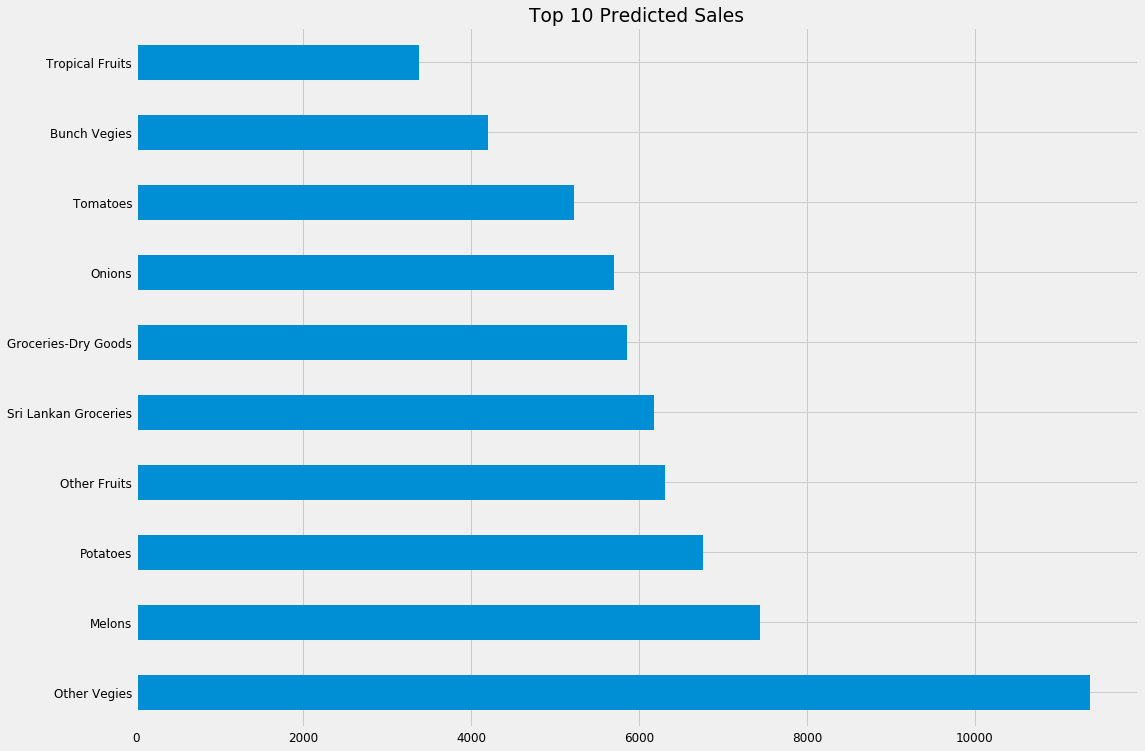

In [56]:
feat_scores = pd.to_numeric((predicted_sales['Predicted 3 Month Sales']))         
top_feat = feat_scores.nlargest(10)
top_feat.plot(kind='barh')
plt.title("Top 10 Predicted Sales")
plt.savefig('top.png')
plt.show()

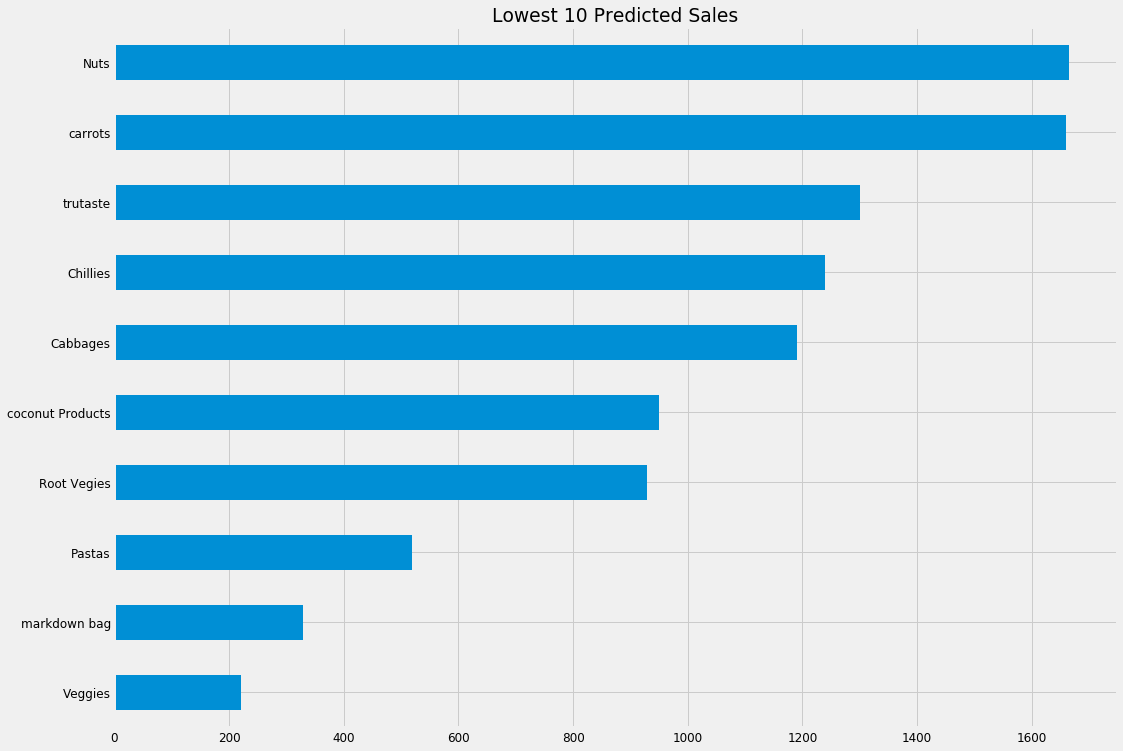

In [57]:

feat_scores = pd.to_numeric((predicted_sales['Predicted 3 Month Sales']))         
top_feat = feat_scores.nsmallest(10)
top_feat.plot(kind='barh')
plt.title("Lowest 10 Predicted Sales")
plt.savefig('low.png')
plt.show()